# Plot panel of Gregory plot for each model with fixed-SST forcing

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import importlib
import my_functions as f
importlib.reload(f) # needed to load new changes in my_functions

<module 'my_functions' from '/Users/hege-beatefredriksen/OneDrive - UiT Office 365/Papers/ForcingCMIP6/CMIP6-forcing/notebooks/my_functions.py'>

In [3]:
exp = 'abrupt-4xCO2'

# load fixed-SST forcings
fixedSSTforcingfile = '../Estimates/fixed_SST_forcing_estimates.txt'
fSSTf_df = pd.read_table(fixedSSTforcingfile, index_col=0, sep = '\t')
models = fSSTf_df.index.drop_duplicates()
models

Index(['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'EC-Earth3', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL'],
      dtype='object')

In [6]:
members = ['r1i1p1f1']*18 # true for most models
main_members = pd.DataFrame(members, index=models)
# change this for models where there is another member
main_members.loc['CNRM-CM6-1', 'CNRM-ESM2-1', 'UKESM1-0-LL'] = 'r1i1p1f2'
main_members.loc['HadGEM3-GC31-LL'] = 'r1i1p1f3'
main_members.loc['EC-Earth3'] = 'r3i1p1f1'
main_members


,0
ACCESS-CM2,r1i1p1f1
ACCESS-ESM1-5,r1i1p1f1
CESM2,r1i1p1f1
CNRM-CM6-1,r1i1p1f2
CNRM-ESM2-1,r1i1p1f2
CanESM5,r1i1p1f1
EC-Earth3,r3i1p1f1
GFDL-CM4,r1i1p1f1
GFDL-ESM4,r1i1p1f1
GISS-E2-1-G,r1i1p1f1


## Test code for one model first:

In [7]:
model = models[6]
model

'EC-Earth3'

In [10]:
f.find_members(model,exp)

['r3i1p1f1', 'r8i1p1f1']

In [8]:
# check which members are available:
directory = '../Processed_data/Global_annual_anomalies/'
modelexpdirectory = os.path.join(directory, model, exp)
filenames = [f.name for f in os.scandir(modelexpdirectory) if f.name !='.ipynb_checkpoints']

members = [file.rsplit('_')[2] for file in filenames]
members.sort()
members

['r3i1p1f1', 'r8i1p1f1']

In [11]:
main_member = main_members.loc[model].values
nmembers = len(fSSTf_df.index[fSSTf_df.index == model])

if nmembers == 1:
    model_df = pd.DataFrame([fSSTf_df.loc[model]])
else:
    model_df = fSSTf_df.loc[model]

memberlist = model_df['member'].values
print('Fixed-SST forcing estimate exists for', nmembers, 'member(s) of this model:', memberlist)
if main_member in memberlist:
    fSSTrow = model_df[model_df['member'] == main_member]
    fSSTf = fSSTrow['F_4xCO2']
    print('Fixed-SST forcing for main member', main_member, 'is', fSSTf[0], 'W/m^2')
else:
    print('but not for the main member', main_member)

Fixed-SST forcing estimate exists for 1 member(s) of this model: ['r1i1p1f1']
but not for the main member ['r3i1p1f1']


r3i1p1f1
r8i1p1f1


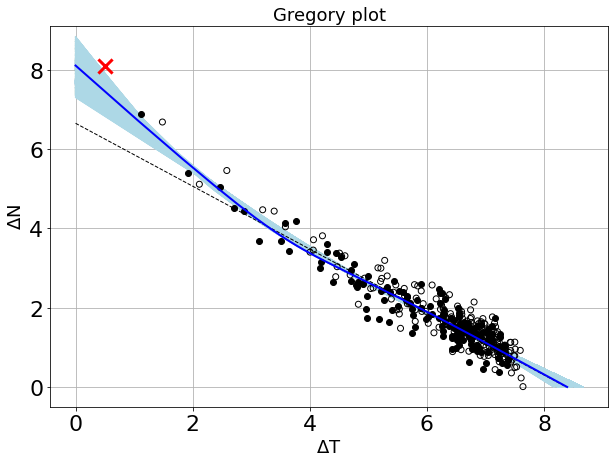

In [8]:
# Gregory plot with all available 4xCO2 data
fig, ax = plt.subplots(figsize = [10,7])

for filename in filenames:
    file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)
    data_i = pd.read_table(file, index_col=0, sep = ',')
    data_i = data_i.dropna()

    deltaN = data_i['rsdt'] - data_i['rsut'] - data_i['rlut']
    deltaT = data_i['tas']
    member_i = filename.rsplit('_')[2]
    print(member_i)
    
    if member_i == main_member:
        ax.scatter(deltaT, deltaN,linewidth=1,color = "black",zorder=999)
        # find linear fit to these points:
        p1 = np.polyfit(deltaT, deltaN, deg = 1)
        deltaTextended = np.concatenate(([0],deltaT,[-p1[1]/p1[0]]))
        linfit = np.polyval(p1,deltaTextended)
        ax.plot(deltaTextended,linfit,'--',linewidth=1,color = "black",zorder=999)
    else:
        ax.scatter(deltaT, deltaN,linewidth=1,color = "black", facecolors='none',zorder=998)
    
ax.set_xlabel('$\Delta$T',fontsize = 18)
ax.set_ylabel('$\Delta$N',fontsize = 18)
ax.set_title('Gregory plot',fontsize = 18)
ax.grid()
ax.tick_params(axis='both',labelsize=22)

# include fixed-SST forcing
for member_f in memberlist:
    fSSTrow = model_df[model_df['member'] == member_f]
    ax.scatter(fSSTrow['$\Delta$T'].values, fSSTrow['F_4xCO2'].values, color = "red", marker = 'x', s=200, linewidth = 3,zorder=1000)

    ax.set_ylim(-0.5, fSSTrow['F_4xCO2'].values+1);
    
    
    
# include 1000 fits
filename = model + '_' + main_member[0] + '_1000parameters.txt'
df_par = pd.read_table('../Estimates/1000parameters_4xCO2/' + filename,index_col=0)
N = len(df_par)

deltaT0 = np.concatenate(([0],deltaT))
years = np.arange(1,150+1); years0 = np.concatenate(([0],years))
timepoints = np.arange(0,151)


best_rnorm = np.min(df_par['rnorm']);
for ii in range(N):
    # load parameters from dataframe:
    taulist = np.array(df_par.loc[ii,'tau1':'tau4'])
    a_n = np.array(df_par.loc[ii,'a_1':'a_4'])
    b_n = np.array(df_par.loc[ii,'b_1':'b_4'])
    F2x = df_par.loc[ii,'F2x']
    T2x = df_par.loc[ii,'T2x']
    rnorm = df_par.loc[ii,'rnorm']
    
    dim = len(taulist) 
    ######### compute components of T from already estimated parameters: #########
    A = np.zeros((len(years)+1,dim))
    for i in range(0,dim): # compute the predictors in the linear model for deltaT
        A[:,i] = (1 - np.exp((-np.arange(0,151))/taulist[i]))
    Ti = np.array([A[:,i]*a_n[i] for i in range(0,dim)]) # compute components
    Tsum = A@a_n # sum of all components
    
    ######### Compute components of N from already estimated paramters: ######### 
    A4 = np.zeros((len(years0),dim))
    for i in range(0,dim): # compute the predictors in the linear model for deltaN  
        A4[:,i] = np.exp((-years0)/taulist[i])    
    Ni = np.array([A4[:,i]*b_n[i] for i in range(0,dim)]) # compute components
    Nsum = A4@b_n # sum of all components   

    # add extra point in equilibrium:
    Tsumext = np.append(Tsum, 2*T2x)
    Nsumext = np.append(Nsum, 0)
    
    if rnorm == best_rnorm: # best estimate
        ax.plot(Tsumext,Nsumext,linewidth=2,color = "blue",zorder=999);
    else: 
        ax.plot(Tsumext,Nsumext,linewidth=1,color = "lightblue",zorder=997);
        


## Loop through all models

available members for model ACCESS-CM2 ['r1i1p1f1']
Fixed-SST forcing estimate exists for 1 member(s) of this model: ['r1i1p1f1']
available members for model ACCESS-ESM1-5 ['r1i1p1f1']
Fixed-SST forcing estimate exists for 1 member(s) of this model: ['r1i1p1f1']
available members for model CESM2 ['r1i1p1f1']
Fixed-SST forcing estimate exists for 1 member(s) of this model: ['r1i1p1f1']
available members for model CNRM-CM6-1 ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f2', 'r6i1p1f2']
Fixed-SST forcing estimate exists for 1 member(s) of this model: ['r1i1p1f2']
available members for model CNRM-ESM2-1 ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2']
Fixed-SST forcing estimate exists for 1 member(s) of this model: ['r1i1p1f2']
available members for model CanESM5 ['r1i1p1f1', 'r1i1p2f1']
Fixed-SST forcing estimate exists for 1 member(s) of this model: ['r1i1p2f1']
but not for the main member ['r1i1p1f1']
available members for model EC-Earth3 ['r3i1p1f1', 'r8i1p1f1']
Fixed-SST forcing estima

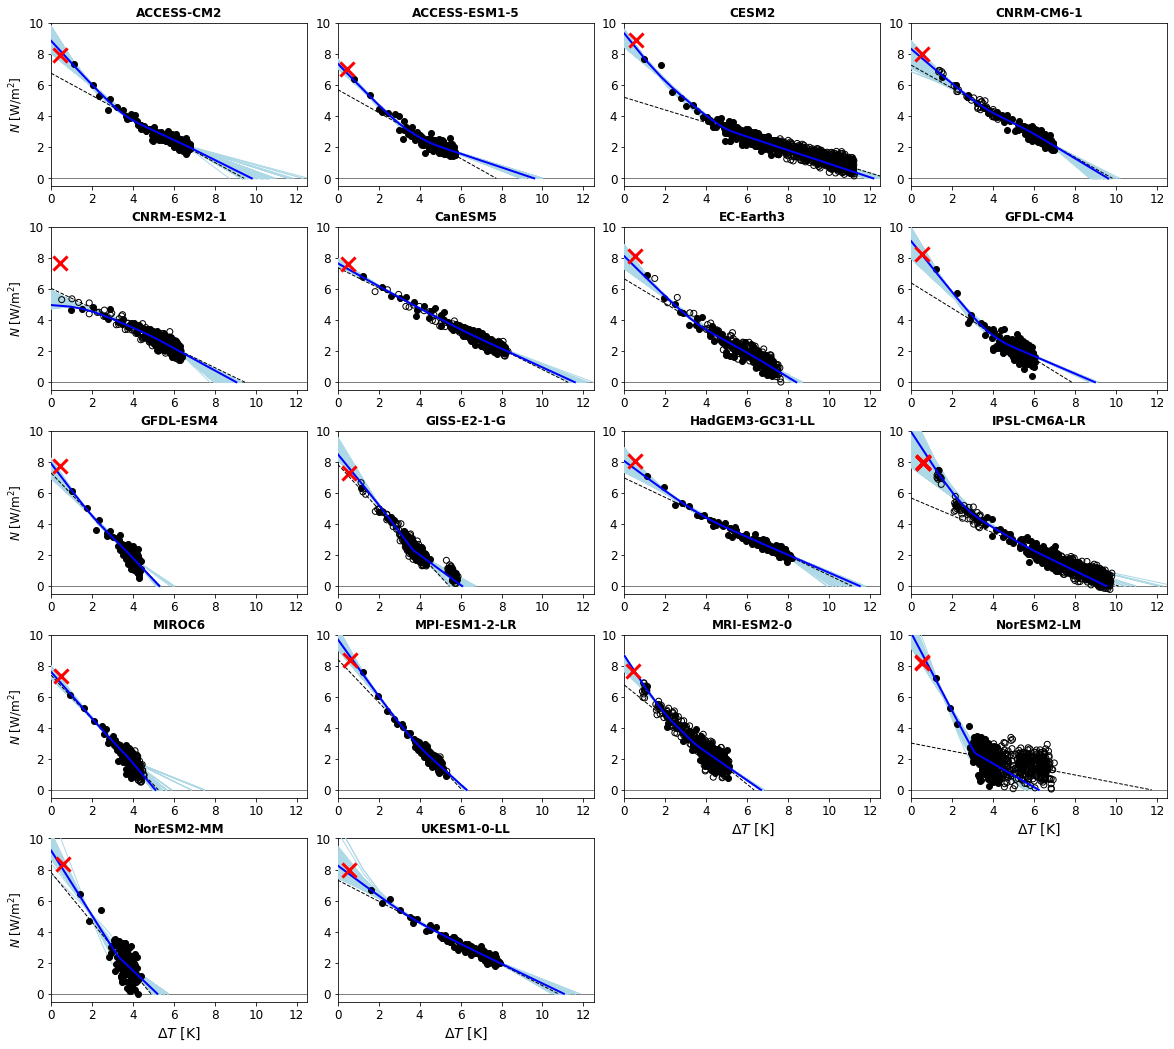

In [9]:
fig, axes = plt.subplots(ncols = 4, nrows = 5, figsize = (20,18))
axes = np.concatenate(axes)

#deltaT0 = np.concatenate(([0],deltaT))
years = np.arange(1,150+1); years0 = np.concatenate(([0],years))
timepoints = np.arange(0,151)

for (j, model) in enumerate(models):
    ax = axes[j]
    if j in [16,17,14,15]:
        ax.set_xlabel('$\Delta T$ [K]', fontsize = 14)
    if j in [0,4,8,12,16]:
        ax.set_ylabel('$N$ [W/m$^2$]', fontsize = 12)
    ax.tick_params(axis='both', labelsize = 12)
    ax.set_title(model, fontweight = 'bold')
    ax.axhline(0, color='k', linewidth = 0.5) # horizontal lines
    ax.set_xlim(0,12.5)
    ax.set_ylim(-0.5,10);
    
    # check which members are available:
    directory = '../Processed_data/Global_annual_anomalies/'
    modelexpdirectory = os.path.join(directory, model, exp)
    filenames = [f.name for f in os.scandir(modelexpdirectory) if f.name !='.ipynb_checkpoints']
    members = [file.rsplit('_')[2] for file in filenames]
    members.sort()
    print('available members for model', model, members)
    
    main_member = main_members.loc[model].values
    nmembers = len(fSSTf_df.index[fSSTf_df.index == model])
    if nmembers == 1:
        model_df = pd.DataFrame([fSSTf_df.loc[model]])
    else:
        model_df = fSSTf_df.loc[model]
    memberlist = model_df['member'].values
    print('Fixed-SST forcing estimate exists for', nmembers, 'member(s) of this model:', memberlist)
    if main_member in memberlist:
        fSSTrow = model_df[model_df['member'] == main_member[0]]
        fSSTf = fSSTrow['F_4xCO2']
        #print('Fixed-SST forcing for main member', main_member, 'is', fSSTf[0], 'W/m^2')
    else:
        print('but not for the main member', main_member)
        
    # Gregory plot with all available 4xCO2 data
    for filename in filenames:
        file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)
        data_i = pd.read_table(file, index_col=0, sep = ',')
        data_i = data_i.dropna()

        deltaN = data_i['rsdt'] - data_i['rsut'] - data_i['rlut']
        deltaT = data_i['tas']
        member_i = filename.rsplit('_')[2]
        #print(member_i)

        if member_i == main_member:
            ax.scatter(deltaT[:150], deltaN[:150],linewidth=1,color = "black",zorder=999)
            # find linear fit to these points:
            p1 = np.polyfit(deltaT, deltaN, deg = 1)
            deltaTextended = np.concatenate(([0],deltaT,[-p1[1]/p1[0]]))
            linfit = np.polyval(p1,deltaTextended)
            ax.plot(deltaTextended,linfit,'--',linewidth=1,color = "black",zorder=999)
            if len(deltaT>150):
                ax.scatter(deltaT[150:], deltaN[150:],linewidth=1,color = "black",facecolors='none', zorder=999)
        else:
            ax.scatter(deltaT, deltaN,linewidth=1,color = "black", facecolors='none',zorder=998)

    # include fixed-SST forcing
    for member_f in memberlist:
        fSSTrow = model_df[model_df['member'] == member_f]
        ax.scatter(fSSTrow['$\Delta$T'].values, fSSTrow['F_4xCO2'].values, color = "red", marker = 'x', s=200, linewidth = 3,zorder=1000)

        #ax.set_ylim(-0.5, fSSTrow['F_4xCO2'].values+2);

    # include 1000 fits
    filename = model + '_' + main_member[0] + '_1000parameters.txt'
    df_par = pd.read_table('../Estimates/1000parameters_4xCO2/' + filename,index_col=0)
    N = len(df_par)


    best_rnorm = np.min(df_par['rnorm']);
    for ii in range(N):
        # load parameters from dataframe:
        taulist = np.array(df_par.loc[ii,'tau1':'tau4'])
        a_n = np.array(df_par.loc[ii,'a_1':'a_4'])
        b_n = np.array(df_par.loc[ii,'b_1':'b_4'])
        F2x = df_par.loc[ii,'F2x']
        T2x = df_par.loc[ii,'T2x']
        rnorm = df_par.loc[ii,'rnorm']

        dim = len(taulist) 
        ######### compute components of T from already estimated parameters: #########
        A = np.zeros((len(years)+1,dim))
        for i in range(0,dim): # compute the predictors in the linear model for deltaT
            A[:,i] = (1 - np.exp((-np.arange(0,151))/taulist[i]))
        Ti = np.array([A[:,i]*a_n[i] for i in range(0,dim)]) # compute components
        Tsum = A@a_n # sum of all components

        ######### Compute components of N from already estimated paramters: ######### 
        A4 = np.zeros((len(years0),dim))
        for i in range(0,dim): # compute the predictors in the linear model for deltaN  
            A4[:,i] = np.exp((-years0)/taulist[i])    
        Ni = np.array([A4[:,i]*b_n[i] for i in range(0,dim)]) # compute components
        Nsum = A4@b_n # sum of all components   

        # add extra point in equilibrium:
        Tsumext = np.append(Tsum, 2*T2x)
        Nsumext = np.append(Nsum, 0)

        if rnorm == best_rnorm: # best estimate
            ax.plot(Tsumext,Nsumext,linewidth=2,color = "blue",zorder=999);
        else: 
            ax.plot(Tsumext,Nsumext,linewidth=1,color = "lightblue",zorder=997);
        
        
fig.delaxes(axes[-1]); fig.delaxes(axes[-2]); 
#plt.subplots_adjust(hspace=0.3, wspace = 0.15)
plt.subplots_adjust(hspace=0.25, wspace = 0.12)
plt.savefig('../Figures/TOAimbvsT_withfixedSSTforcing.pdf', format='pdf', dpi=600, bbox_inches="tight")
plt.show()

# Plot panel of Gregory plot for each model without fixed-SST forcing

In [18]:
models_with_fsstforcing = models
models_with_fsstforcing

Index(['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'EC-Earth3', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL'],
      dtype='object')

In [24]:
# find all models with anomalies computed for an abrupt-4xCO2 experiment

model_anom_names = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/') if f.is_dir() and f.name !='.ipynb_checkpoints']
models_without_fsstforcing = []
for model in model_anom_names:
    if model not in models_with_fsstforcing:
        anom_exp = [ f.name for f in os.scandir('../Processed_data/Global_annual_anomalies/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
        if 'abrupt-4xCO2' in anom_exp:
            models_without_fsstforcing.append(model)
    
print(len(models_without_fsstforcing), 'models:')
models_without_fsstforcing.sort()
models_without_fsstforcing

31 models:


['AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CIESM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1-HR',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MIROC-ES2L',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'NESM3',
 'NorCPM1',
 'SAM0-UNICON',
 'TaiESM1']

### Since they are so many, make two figures:

In [33]:
model_group1 = models_without_fsstforcing[:16]
model_group2 = models_without_fsstforcing[16:]




In [36]:
members = ['r1i1p1f1']*len(models_without_fsstforcing) # true for most models
main_members = pd.DataFrame(members, index=models_without_fsstforcing)
# change this for models where there is another member
main_members.loc['CNRM-CM6-1-HR'] = 'r1i1p1f2'
main_members.loc['MIROC-ES2L'] = 'r1i1p1f2'
main_members.loc['HadGEM3-GC31-MM'] = 'r1i1p1f3'
main_members

#model = 'AWI-CM-1-1-MR'; member = 'r1i1p1f1'
#model = 'BCC-CSM2-MR'; member = 'r1i1p1f1'
#model = 'BCC-ESM1'; member = 'r1i1p1f1'
#model = 'CAMS-CSM1-0'; member = 'r1i1p1f1'
#model = 'CAMS-CSM1-0'; member = 'r2i1p1f1'
#model = 'CAS-ESM2-0'; member = 'r1i1p1f1'
#model = 'CESM2-FV2'; member = 'r1i1p1f1'
#model = 'CESM2-WACCM'; member = 'r1i1p1f1'
#model = 'CESM2-WACCM-FV2'; member = 'r1i1p1f1'
#model = 'CIESM'; member = 'r1i1p1f1'
#model = 'CMCC-CM2-SR5'; member = 'r1i1p1f1'
#model = 'CNRM-CM6-1'; member = 'r1i1p1f2'
#model = 'CNRM-CM6-1-HR'; member = 'r1i1p1f2'
#model = 'E3SM-1-0'; member = 'r1i1p1f1'
#model = 'EC-Earth3-Veg'; member = 'r1i1p1f1'
#model = 'FGOALS-f3-L'; member = 'r1i1p1f1'
#model = 'FGOALS-f3-L'; member = 'r2i1p1f1'
#model = 'FGOALS-f3-L'; member = 'r3i1p1f1'
#model = 'FGOALS-g3'; member = 'r1i1p1f1'
#model = 'FIO-ESM-2-0';  member = 'r1i1p1f1'
#model = 'FIO-ESM-2-0';  member = 'r2i1p1f1' # something weird happens in this run
#model = 'FIO-ESM-2-0';  member = 'r3i1p1f1' 
#model = 'GISS-E2-1-H'; member = 'r1i1p1f1' # rerun this after obtaining missing years
#model = 'GISS-E2-1-H'; member = 'r1i1p3f1' # rerun this after obtaining missing years
#model = 'GISS-E2-1-H'; member = 'r1i1p5f1' # this member is requested
#model = 'GISS-E2-2-G'; member = 'r1i1p1f1'
#model = 'HadGEM3-GC31-MM'; member = 'r1i1p1f3'
#model = 'IITM-ESM'; member = 'r1i1p1f1'
#model = 'INM-CM4-8'; member = 'r1i1p1f1'
#model = 'INM-CM5-0'; member = 'r1i1p1f1'
#model = 'KACE-1-0-G'; member = 'r1i1p1f1'
#model = 'KIOST-ESM'; member = 'r1i1p1f1'
#model = 'MIROC-ES2L'; member = 'r1i1p1f2'
#model = 'MPI-ESM-1-2-HAM'; member = 'r1i1p1f1'
#model = 'MPI-ESM1-2-HR'; member = 'r1i1p1f1'
#model = 'NESM3'; member = 'r1i1p1f1'
#model = 'NorCPM1'; member = 'r1i1p1f1'
#model = 'SAM0-UNICON'; member = 'r1i1p1f1'
#model = 'TaiESM1'; member = 'r1i1p1f1'

,0
AWI-CM-1-1-MR,r1i1p1f1
BCC-CSM2-MR,r1i1p1f1
BCC-ESM1,r1i1p1f1
CAMS-CSM1-0,r1i1p1f1
CAS-ESM2-0,r1i1p1f1
CESM2-FV2,r1i1p1f1
CESM2-WACCM,r1i1p1f1
CESM2-WACCM-FV2,r1i1p1f1
CIESM,r1i1p1f1
CMCC-CM2-SR5,r1i1p1f1


### Loop through model group 1

available members for model AWI-CM-1-1-MR ['r1i1p1f1']
available members for model BCC-CSM2-MR ['r1i1p1f1']
available members for model BCC-ESM1 ['r1i1p1f1']
available members for model CAMS-CSM1-0 ['r1i1p1f1', 'r2i1p1f1']
available members for model CAS-ESM2-0 ['r1i1p1f1']
available members for model CESM2-FV2 ['r1i1p1f1']
available members for model CESM2-WACCM ['r1i1p1f1']
available members for model CESM2-WACCM-FV2 ['r1i1p1f1']
available members for model CIESM ['r1i1p1f1']
available members for model CMCC-CM2-SR5 ['r1i1p1f1']
available members for model CNRM-CM6-1-HR ['r1i1p1f2']
available members for model E3SM-1-0 ['r1i1p1f1']
available members for model EC-Earth3-Veg ['r1i1p1f1']
available members for model FGOALS-f3-L ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
available members for model FGOALS-g3 ['r1i1p1f1']
available members for model FIO-ESM-2-0 ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']


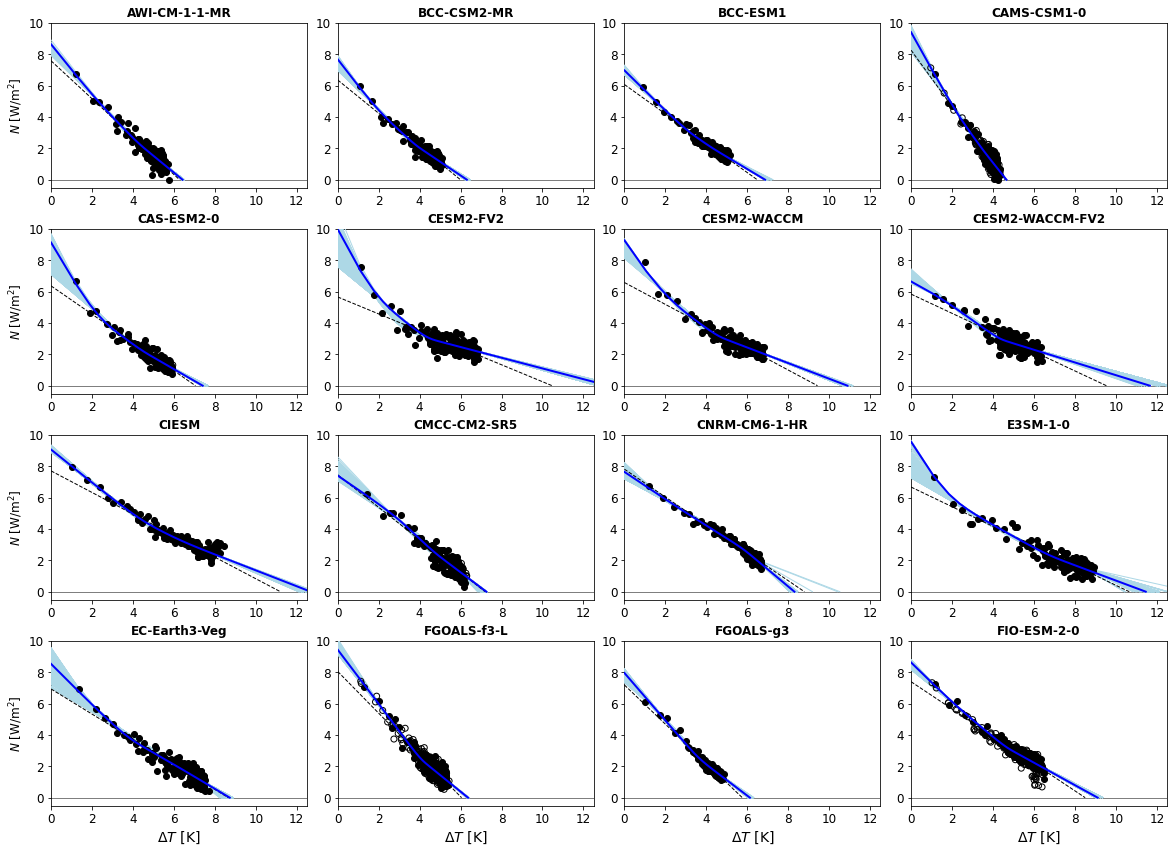

In [43]:
fig, axes = plt.subplots(ncols = 4, nrows = 4, figsize = (20,18/5*4))
axes = np.concatenate(axes)

years = np.arange(1,150+1); years0 = np.concatenate(([0],years))
timepoints = np.arange(0,151)

for (j, model) in enumerate(model_group1):
    ax = axes[j]
    if j in [12,13,14,15]:
        ax.set_xlabel('$\Delta T$ [K]', fontsize = 14)
    if j in [0,4,8,12]:
        ax.set_ylabel('$N$ [W/m$^2$]', fontsize = 12)
    ax.tick_params(axis='both', labelsize = 12)
    ax.set_title(model, fontweight = 'bold')
    ax.axhline(0, color='k', linewidth = 0.5) # horizontal lines
    ax.set_xlim(0,12.5)
    ax.set_ylim(-0.5,10);
    
    # check which members are available:
    directory = '../Processed_data/Global_annual_anomalies/'
    modelexpdirectory = os.path.join(directory, model, exp)
    filenames = [f.name for f in os.scandir(modelexpdirectory) if f.name !='.ipynb_checkpoints']
    members = [file.rsplit('_')[2] for file in filenames]
    members.sort()
    print('available members for model', model, members)
    
    main_member = main_members.loc[model].values
        
    # Gregory plot with all available 4xCO2 data
    for filename in filenames:
        file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)
        data_i = pd.read_table(file, index_col=0, sep = ',')
        data_i = data_i.dropna()

        deltaN = data_i['rsdt'] - data_i['rsut'] - data_i['rlut']
        deltaT = data_i['tas']; #deltaT0 = np.concatenate(([0],deltaT))
        member_i = filename.rsplit('_')[2]
        #print(member_i)

        if member_i == main_member:
            ax.scatter(deltaT[:150], deltaN[:150],linewidth=1,color = "black",zorder=999)
            # find linear fit to these points:
            p1 = np.polyfit(deltaT, deltaN, deg = 1)
            deltaTextended = np.concatenate(([0],deltaT,[-p1[1]/p1[0]]))
            linfit = np.polyval(p1,deltaTextended)
            ax.plot(deltaTextended,linfit,'--',linewidth=1,color = "black",zorder=999)
            if len(deltaT>150):
                ax.scatter(deltaT[150:], deltaN[150:],linewidth=1,color = "black",facecolors='none', zorder=999)
        else:
            ax.scatter(deltaT, deltaN,linewidth=1,color = "black", facecolors='none',zorder=998)

    # include 1000 fits
    filename = model + '_' + main_member[0] + '_1000parameters.txt'
    df_par = pd.read_table('../Estimates/1000parameters_4xCO2/' + filename,index_col=0)
    N = len(df_par)


    best_rnorm = np.min(df_par['rnorm']);
    for ii in range(N):
        # load parameters from dataframe:
        taulist = np.array(df_par.loc[ii,'tau1':'tau4'])
        a_n = np.array(df_par.loc[ii,'a_1':'a_4'])
        b_n = np.array(df_par.loc[ii,'b_1':'b_4'])
        F2x = df_par.loc[ii,'F2x']
        T2x = df_par.loc[ii,'T2x']
        rnorm = df_par.loc[ii,'rnorm']

        dim = len(taulist) 
        ######### compute components of T from already estimated parameters: #########
        A = np.zeros((len(years)+1,dim))
        for i in range(0,dim): # compute the predictors in the linear model for deltaT
            A[:,i] = (1 - np.exp((-np.arange(0,151))/taulist[i]))
        Ti = np.array([A[:,i]*a_n[i] for i in range(0,dim)]) # compute components
        Tsum = A@a_n # sum of all components

        ######### Compute components of N from already estimated paramters: ######### 
        A4 = np.zeros((len(years0),dim))
        for i in range(0,dim): # compute the predictors in the linear model for deltaN  
            A4[:,i] = np.exp((-years0)/taulist[i])    
        Ni = np.array([A4[:,i]*b_n[i] for i in range(0,dim)]) # compute components
        Nsum = A4@b_n # sum of all components   

        # add extra point in equilibrium:
        Tsumext = np.append(Tsum, 2*T2x)
        Nsumext = np.append(Nsum, 0)

        if rnorm == best_rnorm: # best estimate
            ax.plot(Tsumext,Nsumext,linewidth=2,color = "blue",zorder=999);
        else: 
            ax.plot(Tsumext,Nsumext,linewidth=1,color = "lightblue",zorder=997);
        
        
#fig.delaxes(axes[-1]); fig.delaxes(axes[-2]); 
#plt.subplots_adjust(hspace=0.3, wspace = 0.15)
plt.subplots_adjust(hspace=0.25, wspace = 0.12)
plt.savefig('../Figures/TOAimbvsT_withoutfixedSSTforcing_group1.pdf', format='pdf', dpi=600, bbox_inches="tight")
plt.show()

### Loop through model group 2

available members for model GISS-E2-1-H ['r1i1p1f1', 'r1i1p3f1']
available members for model GISS-E2-2-G ['r1i1p1f1']
available members for model HadGEM3-GC31-MM ['r1i1p1f3']
available members for model IITM-ESM ['r1i1p1f1']
available members for model INM-CM4-8 ['r1i1p1f1']
available members for model INM-CM5-0 ['r1i1p1f1']
available members for model KACE-1-0-G ['r1i1p1f1']
available members for model KIOST-ESM ['r1i1p1f1']
available members for model MIROC-ES2L ['r1i1p1f2']
available members for model MPI-ESM-1-2-HAM ['r1i1p1f1']
available members for model MPI-ESM1-2-HR ['r1i1p1f1']
available members for model NESM3 ['r1i1p1f1']
available members for model NorCPM1 ['r1i1p1f1']
available members for model SAM0-UNICON ['r1i1p1f1']
available members for model TaiESM1 ['r1i1p1f1']


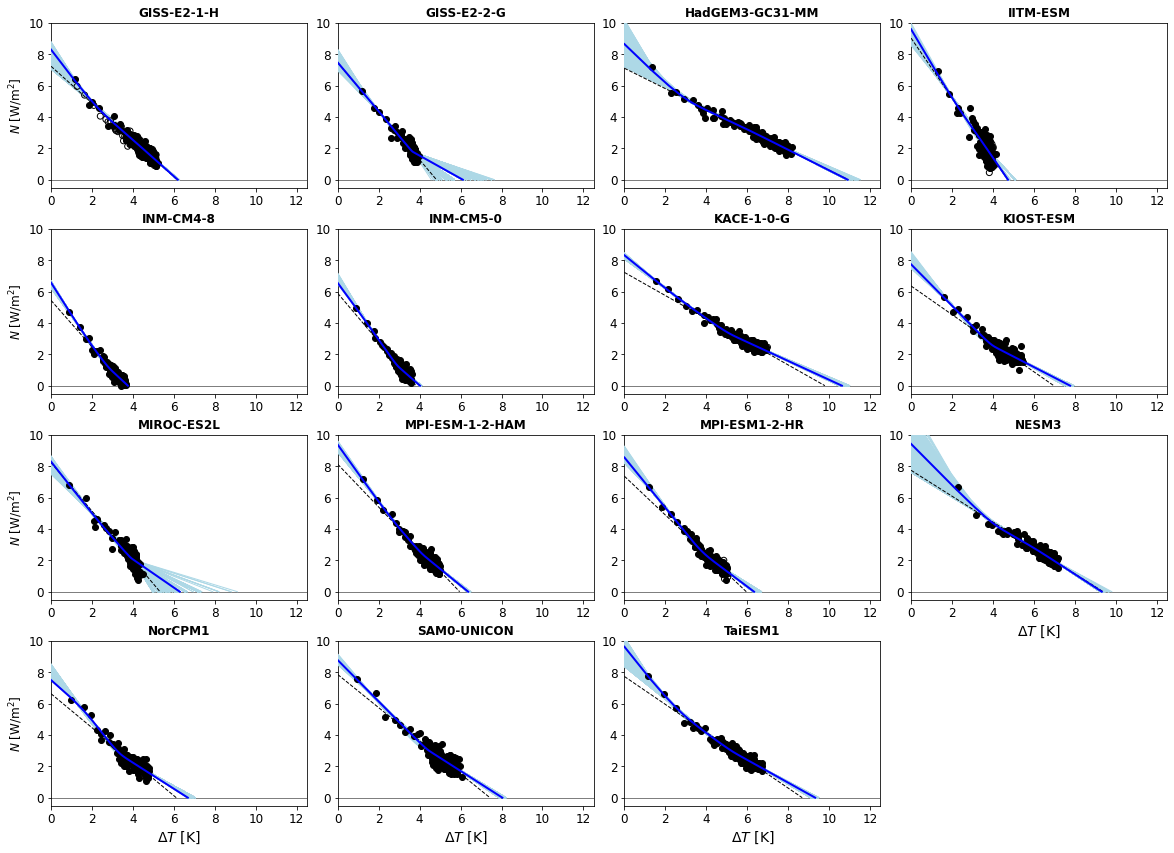

In [44]:
fig, axes = plt.subplots(ncols = 4, nrows = 4, figsize = (20,18/5*4))
axes = np.concatenate(axes)

years = np.arange(1,150+1); years0 = np.concatenate(([0],years))
timepoints = np.arange(0,151)

for (j, model) in enumerate(model_group2):
    ax = axes[j]
    if j in [12,13,14,11]:
        ax.set_xlabel('$\Delta T$ [K]', fontsize = 14)
    if j in [0,4,8,12]:
        ax.set_ylabel('$N$ [W/m$^2$]', fontsize = 12)
    ax.tick_params(axis='both', labelsize = 12)
    ax.set_title(model, fontweight = 'bold')
    ax.axhline(0, color='k', linewidth = 0.5) # horizontal lines
    ax.set_xlim(0,12.5)
    ax.set_ylim(-0.5,10);
    
    # check which members are available:
    directory = '../Processed_data/Global_annual_anomalies/'
    modelexpdirectory = os.path.join(directory, model, exp)
    filenames = [f.name for f in os.scandir(modelexpdirectory) if f.name !='.ipynb_checkpoints']
    members = [file.rsplit('_')[2] for file in filenames]
    members.sort()
    print('available members for model', model, members)
    
    main_member = main_members.loc[model].values
        
    # Gregory plot with all available 4xCO2 data
    for filename in filenames:
        file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)
        data_i = pd.read_table(file, index_col=0, sep = ',')
        data_i = data_i.dropna()

        deltaN = data_i['rsdt'] - data_i['rsut'] - data_i['rlut']
        deltaT = data_i['tas']; #deltaT0 = np.concatenate(([0],deltaT))
        member_i = filename.rsplit('_')[2]
        #print(member_i)

        if member_i == main_member:
            ax.scatter(deltaT[:150], deltaN[:150],linewidth=1,color = "black",zorder=999)
            # find linear fit to these points:
            p1 = np.polyfit(deltaT, deltaN, deg = 1)
            deltaTextended = np.concatenate(([0],deltaT,[-p1[1]/p1[0]]))
            linfit = np.polyval(p1,deltaTextended)
            ax.plot(deltaTextended,linfit,'--',linewidth=1,color = "black",zorder=999)
            if len(deltaT>150):
                ax.scatter(deltaT[150:], deltaN[150:],linewidth=1,color = "black",facecolors='none', zorder=999)
        else:
            ax.scatter(deltaT, deltaN,linewidth=1,color = "black", facecolors='none',zorder=998)

    # include 1000 fits
    filename = model + '_' + main_member[0] + '_1000parameters.txt'
    df_par = pd.read_table('../Estimates/1000parameters_4xCO2/' + filename,index_col=0)
    N = len(df_par)


    best_rnorm = np.min(df_par['rnorm']);
    for ii in range(N):
        # load parameters from dataframe:
        taulist = np.array(df_par.loc[ii,'tau1':'tau4'])
        a_n = np.array(df_par.loc[ii,'a_1':'a_4'])
        b_n = np.array(df_par.loc[ii,'b_1':'b_4'])
        F2x = df_par.loc[ii,'F2x']
        T2x = df_par.loc[ii,'T2x']
        rnorm = df_par.loc[ii,'rnorm']

        dim = len(taulist) 
        ######### compute components of T from already estimated parameters: #########
        A = np.zeros((len(years)+1,dim))
        for i in range(0,dim): # compute the predictors in the linear model for deltaT
            A[:,i] = (1 - np.exp((-np.arange(0,151))/taulist[i]))
        Ti = np.array([A[:,i]*a_n[i] for i in range(0,dim)]) # compute components
        Tsum = A@a_n # sum of all components

        ######### Compute components of N from already estimated paramters: ######### 
        A4 = np.zeros((len(years0),dim))
        for i in range(0,dim): # compute the predictors in the linear model for deltaN  
            A4[:,i] = np.exp((-years0)/taulist[i])    
        Ni = np.array([A4[:,i]*b_n[i] for i in range(0,dim)]) # compute components
        Nsum = A4@b_n # sum of all components   

        # add extra point in equilibrium:
        Tsumext = np.append(Tsum, 2*T2x)
        Nsumext = np.append(Nsum, 0)

        if rnorm == best_rnorm: # best estimate
            ax.plot(Tsumext,Nsumext,linewidth=2,color = "blue",zorder=999);
        else: 
            ax.plot(Tsumext,Nsumext,linewidth=1,color = "lightblue",zorder=997);
        
        
fig.delaxes(axes[-1]);
#plt.subplots_adjust(hspace=0.3, wspace = 0.15)
plt.subplots_adjust(hspace=0.25, wspace = 0.12)
plt.savefig('../Figures/TOAimbvsT_withoutfixedSSTforcing_group2.pdf', format='pdf', dpi=600, bbox_inches="tight")
plt.show()